# Imports

In [1]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates
from statsmodels.tsa.ar_model import AR 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import statsmodels.api as sm
# plt.style.use('fivethirtyeight')

# Data Reading

In [2]:
converters = {'Datum': lambda x: pd.to_datetime(x, format='%d.%m.%Y')}
data = pd.read_csv('./Gro_handelspreise_201901010000_202401312359_stunde (1).csv', sep = ';', converters=converters, encoding='utf-8')
data

,Datum,Anfang,Ende,Deutschland/Luxemburg [€/MWh] Originalauflösungen,∅ Anrainer DE/LU [€/MWh] Originalauflösungen,Belgien [€/MWh] Originalauflösungen,Dänemark 1 [€/MWh] Originalauflösungen,Dänemark 2 [€/MWh] Originalauflösungen,Frankreich [€/MWh] Originalauflösungen,Niederlande [€/MWh] Originalauflösungen,Norwegen 2 [€/MWh] Originalauflösungen,Österreich [€/MWh] Originalauflösungen,Polen [€/MWh] Originalauflösungen,Schweden 4 [€/MWh] Originalauflösungen,Schweiz [€/MWh] Originalauflösungen,Tschechien [€/MWh] Originalauflösungen,DE/AT/LU [€/MWh] Originalauflösungen,Italien (Nord) [€/MWh] Originalauflösungen,Slowenien [€/MWh] Originalauflösungen,Ungarn [€/MWh] Originalauflösungen
0,2019-01-01,00:00,01:00,"28,32",-,"69,49","28,32","28,32",51,"68,92","48,77","33,48",-,"28,32","50,26","8,5",-,51,51,"59,9"
1,2019-01-01,01:00,02:00,"10,07",-,"66,58","10,07","10,07","46,27","64,98","49,25","39,76",-,"10,07","48,74","3,97",-,"46,27","46,27","52,71"
2,2019-01-01,02:00,03:00,"-4,08",-,"65,07","-4,08","-4,08","39,78","60,27","49,17","39,78",-,"10,03","47,24","4,7",-,"39,78","39,78","36,49"
3,2019-01-01,03:00,04:00,"-9,91",-,"52,17","-9,91","-9,91","27,87","49,97","48,37","27,87",-,"4,56","36,29","0,93",-,"27,87","27,87","31,24"
4,2019-01-01,04:00,05:00,"-7,41",-,"47,66","-7,41","-7,41","23,21","47,66","47,19","-0,36",-,"4,83","30,09","3,9",-,22,"-0,36","25,98"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40122,2023-07-30,19:00,20:00,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
40123,2023-07-30,20:00,21:00,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
40124,2023-07-30,21:00,22:00,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
40125,2023-07-30,22:00,23:00,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


# Data Cleanning 

#### Function for Data Cleanning

* **The function add_decimals does the following tasks**
    1. replaces ',' in the decimal place with '.'
    1. replaces '.' in the thousands place with ''
    1. replaces the missing values with 0

* **The function add_timestamp does the following tasks**
    1. Add the columns Date and anfang to column Timestamp

In [3]:
def add_decimal(data, column_names):
    new_data = data.copy(deep=True)
    for i in column_names:
        new_data[i] = new_data[i].str.replace('.','').str.replace(',','.')
        new_data = new_data.replace('-','0')
        new_data[i] = new_data[i].astype(np.float32)
    return new_data

def add_timestamp(data):
    new_data = data.copy(deep=True)
    new_data.insert(0,'Timestamp',pd.to_datetime(data['Datum'].astype(str) + ' ' + data['Anfang']))
    new_data.drop(columns=['Datum','Anfang','Ende'], inplace = True)
    return new_data

In [4]:
data = add_decimal(data,['Deutschland/Luxemburg [€/MWh] Originalauflösungen',
 '∅ Anrainer DE/LU [€/MWh] Originalauflösungen',
 'Belgien [€/MWh] Originalauflösungen',
 'Dänemark 1 [€/MWh] Originalauflösungen',
 'Dänemark 2 [€/MWh] Originalauflösungen',
 'Frankreich [€/MWh] Originalauflösungen',
 'Niederlande [€/MWh] Originalauflösungen',
 'Norwegen 2 [€/MWh] Originalauflösungen',
 'Österreich [€/MWh] Originalauflösungen',
 'Polen [€/MWh] Originalauflösungen',
 'Schweden 4 [€/MWh] Originalauflösungen',
 'Schweiz [€/MWh] Originalauflösungen',
 'Tschechien [€/MWh] Originalauflösungen',
 'DE/AT/LU [€/MWh] Originalauflösungen',
 'Italien (Nord) [€/MWh] Originalauflösungen',
 'Slowenien [€/MWh] Originalauflösungen',
 'Ungarn [€/MWh] Originalauflösungen'])

data = add_timestamp(data)

# Data Analysis

The Data for only 2023 is considered as the data prediction is to be done only the next 48 hours. The data with lag for more than 100 datapoints doesn't show any significant effect on the current data point

In [5]:
data = data[(data['Timestamp'].dt.year == 2023)]
data = data[(pd.to_datetime(data['Timestamp'], format='%Y-%m-%d').dt.date < pd.to_datetime('2023-07-28', format='%Y-%m-%d').date())].reset_index(drop=True)

In [6]:
data

,Timestamp,Deutschland/Luxemburg [€/MWh] Originalauflösungen,∅ Anrainer DE/LU [€/MWh] Originalauflösungen,Belgien [€/MWh] Originalauflösungen,Dänemark 1 [€/MWh] Originalauflösungen,Dänemark 2 [€/MWh] Originalauflösungen,Frankreich [€/MWh] Originalauflösungen,Niederlande [€/MWh] Originalauflösungen,Norwegen 2 [€/MWh] Originalauflösungen,Österreich [€/MWh] Originalauflösungen,Polen [€/MWh] Originalauflösungen,Schweden 4 [€/MWh] Originalauflösungen,Schweiz [€/MWh] Originalauflösungen,Tschechien [€/MWh] Originalauflösungen,DE/AT/LU [€/MWh] Originalauflösungen,Italien (Nord) [€/MWh] Originalauflösungen,Slowenien [€/MWh] Originalauflösungen,Ungarn [€/MWh] Originalauflösungen
0,2023-01-01 00:00:00,-5.170000,13.850000,-4.390000,2.010000,2.010000,0.000000,-3.610000,119.320000,12.060000,18.090000,2.010000,0.030000,4.840000,0.0,195.899994,13.310000,19.760000
1,2023-01-01 01:00:00,-1.070000,9.790000,-1.750000,1.380000,1.380000,-0.100000,-1.460000,108.830002,-0.100000,5.750000,1.380000,-7.250000,-0.350000,0.0,191.089996,-0.070000,0.190000
2,2023-01-01 02:00:00,-1.470000,8.910000,-1.460000,0.090000,0.090000,-1.330000,-1.520000,102.389999,-0.660000,5.270000,0.090000,-3.990000,-0.970000,0.0,187.949997,-0.470000,0.070000
3,2023-01-01 03:00:00,-5.080000,6.580000,-5.270000,0.080000,0.080000,-4.080000,-5.000000,92.360001,-1.990000,5.740000,0.080000,-7.710000,-1.930000,0.0,187.820007,-1.560000,0.010000
4,2023-01-01 04:00:00,-4.490000,5.420000,-4.410000,0.050000,0.050000,-4.160000,-4.600000,82.660004,-2.420000,5.220000,0.050000,-9.710000,-3.070000,0.0,187.740005,-1.940000,-0.770000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4986,2023-07-27 19:00:00,116.949997,106.839996,104.510002,116.949997,116.949997,98.739998,114.330002,84.349998,118.940002,155.539993,36.740002,105.029999,123.120003,0.0,120.570000,124.080002,130.279999
4987,2023-07-27 20:00:00,109.970001,106.820000,110.139999,109.970001,109.970001,111.000000,109.660004,84.260002,114.389999,161.070007,36.349998,109.639999,118.589996,0.0,122.209999,123.010002,129.350006
4988,2023-07-27 21:00:00,108.120003,106.250000,108.639999,108.120003,108.120003,109.870003,107.959999,84.320000,112.480003,167.380005,35.419998,107.959999,118.500000,0.0,115.129997,124.000000,131.190002
4989,2023-07-27 22:00:00,105.559998,103.690002,107.410004,105.559998,105.559998,108.540001,106.639999,84.309998,109.540001,157.820007,34.200001,105.910004,115.089996,0.0,111.529999,119.790001,125.830002


# Data Analysis
Since each column of the csv has an different countries so the Data Analysis for each country will be done seperately

## Analysis for Deutschland/Luxemburg

### ACF (AutoCorrelation Function):

* ACF measures the correlation between a time series and its lagged values at different lags.
* It helps identify the presence of seasonality or repeating patterns in the data.
* A significant spike at a specific lag in the ACF plot suggests a strong correlation with that lag.

### PACF (Partial AutoCorrelation Function):

* PACF measures the correlation between a time series and its lagged values, accounting for the influence of intermediate lags.
* It helps identify the order of the autoregressive component in an ARIMA model.
* A significant spike at a specific lag in the PACF plot suggests a direct correlation with that lag, without the influence of intermediate lags.

In [7]:
data.columns

Index(['Timestamp', 'Deutschland/Luxemburg [€/MWh] Originalauflösungen',
       '∅ Anrainer DE/LU [€/MWh] Originalauflösungen',
       'Belgien [€/MWh] Originalauflösungen',
       'Dänemark 1 [€/MWh] Originalauflösungen',
       'Dänemark 2 [€/MWh] Originalauflösungen',
       'Frankreich [€/MWh] Originalauflösungen',
       'Niederlande [€/MWh] Originalauflösungen',
       'Norwegen 2 [€/MWh] Originalauflösungen',
       'Österreich [€/MWh] Originalauflösungen',
       'Polen [€/MWh] Originalauflösungen',
       'Schweden 4 [€/MWh] Originalauflösungen',
       'Schweiz [€/MWh] Originalauflösungen',
       'Tschechien [€/MWh] Originalauflösungen',
       'DE/AT/LU [€/MWh] Originalauflösungen',
       'Italien (Nord) [€/MWh] Originalauflösungen',
       'Slowenien [€/MWh] Originalauflösungen',
       'Ungarn [€/MWh] Originalauflösungen'],
      dtype='object')

In [8]:
deutschland_df = data[['Timestamp','Deutschland/Luxemburg [€/MWh] Originalauflösungen']].copy(deep=True)

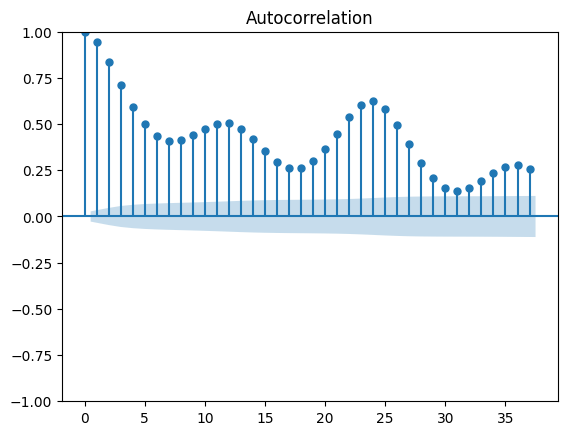

In [9]:
acf_analysis = plot_acf(deutschland_df['Deutschland/Luxemburg [€/MWh] Originalauflösungen'])

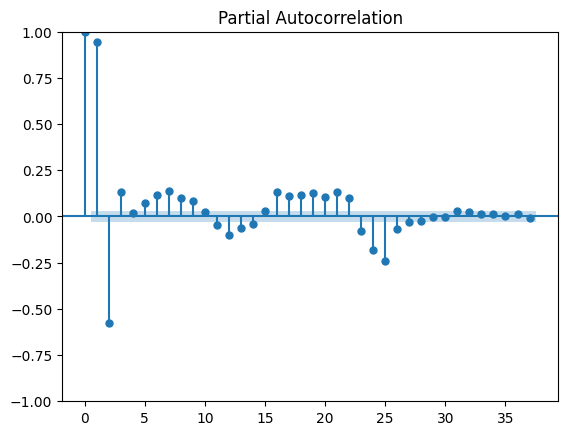

In [10]:
pacf_analysis = plot_pacf(deutschland_df['Deutschland/Luxemburg [€/MWh] Originalauflösungen'])

### ADF Test
The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine if a time series is stationary or non-stationary.

Stationary Time Series:

* A stationary time series has constant mean and variance over time.
* The statistical properties (mean, variance, autocorrelation) do not change with time.
* It is easier to model and forecast stationary time series.

Non-Stationary Time Series:

* A non-stationary time series shows trends, seasonality, or irregular patterns.
* The statistical properties change with time, making it challenging to model and forecast accurately.

ADF Test Significance:

* The ADF test checks if a time series has a unit root (rooted in its own lagged values).
* If the time series has a unit root, it is non-stationary, indicating the presence of a trend or seasonality.
* If the ADF test rejects the null hypothesis (has no unit root), the time series is stationary.

Interpretation:

* If the p-value of the ADF test is below a chosen significance level (e.g., 0.05), we reject the null hypothesis of non-stationarity, indicating a stationary time series.
* If the p-value is above the significance level, we fail to reject the null hypothesis, suggesting a non-stationary time series.

In [11]:
adf_result = adfuller(deutschland_df['Deutschland/Luxemburg [€/MWh] Originalauflösungen'])
print(f"'The values for ADF Statistic':{ adf_result[0]},'p-value': {adf_result[1]}")

'The values for ADF Statistic':-8.246373093228721,'p-value': 5.539977750530473e-13


### Seasonal Decompisition analysis

In [12]:
help(seasonal_decompose)

Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)
    Seasonal decomposition using moving averages.
    
    Parameters
    ----------
    x : array_like
        Time series. If 2d, individual series are in columns. x must contain 2
        complete cycles.
    model : {"additive", "multiplicative"}, optional
        Type of seasonal component. Abbreviations are accepted.
    filt : array_like, optional
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by
        two_sided.
    period : int, optional
        Period of the series. Must be used if x is not a pandas object or if
        the index of x does not have  a frequency. Overrides default
        periodicity of x if x is a pandas object with a timeseries index.
    two_sided : bool, optional
        The moving a

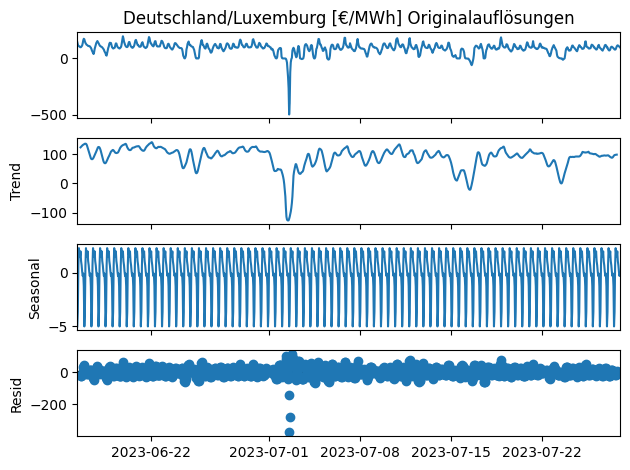

In [13]:
deutschland_df.index = pd.to_datetime(deutschland_df['Timestamp'])
deutschland_df = deutschland_df.tail(1000)
decomposition = sm.tsa.seasonal_decompose(deutschland_df['Deutschland/Luxemburg [€/MWh] Originalauflösungen'],period=13, model='additive').plot()

### Model Fitting

In [33]:
import pmdarima as pm

train_size = int(0.8 * len(deutschland_df))
train_data = deutschland_df[:train_size]
test_data = deutschland_df[train_size:]



Root Mean Squared Error (RMSE): 28.385347440723844


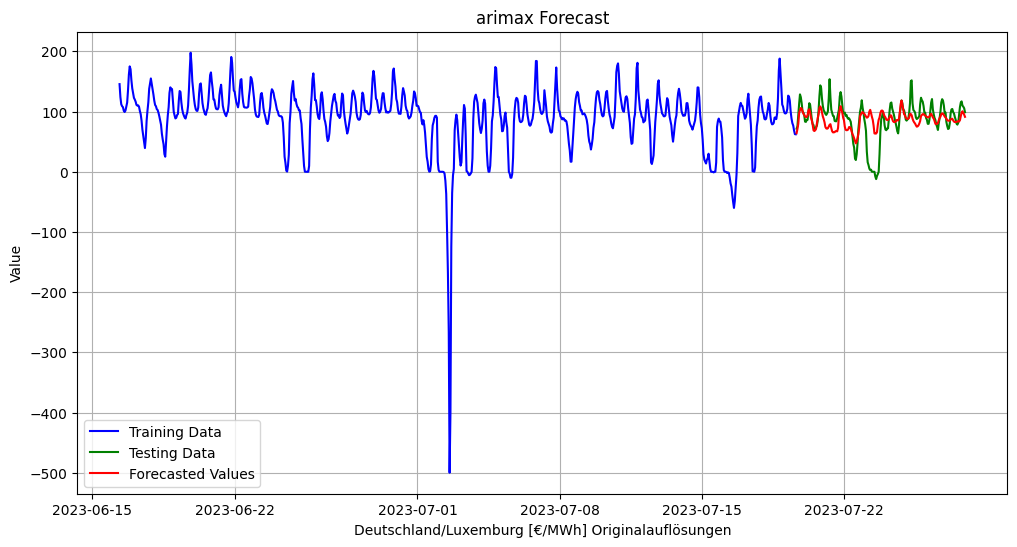

In [32]:
model = pm.ARIMA(order=(0, 0, 0), seasonal_order=(2, 0, 0, 72), suppress_warnings=True)
model.fit(train_data['Deutschland/Luxemburg [€/MWh] Originalauflösungen'])

forecast_values, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)

mse = np.mean((forecast_values - test_data['Deutschland/Luxemburg [€/MWh] Originalauflösungen']) ** 2)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

plt.figure(figsize=(12, 6))
plt.plot(train_data['Timestamp'], train_data['Deutschland/Luxemburg [€/MWh] Originalauflösungen'], label='Training Data', color='blue')
plt.plot(test_data['Timestamp'], test_data['Deutschland/Luxemburg [€/MWh] Originalauflösungen'], label='Testing Data', color='green')
plt.plot(test_data['Timestamp'], forecast_values, label='Forecasted Values', color='red')
plt.xlabel('Deutschland/Luxemburg [€/MWh] Originalauflösungen')
plt.ylabel('Value')
plt.title('arimax Forecast')
plt.legend()
plt.grid(True)
plt.show()